# **Blindness Detection Project**

## **Dataset Description**

This project aims to detect "Diabetic Retinopathy (DR)" to stop blindness at early stage.

A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:

<ul>
<li>0 - No DR</li>
<li>1 - Mild</li>
<li>2 - Moderate</li>
<li>3 - Severe</li>
<li>4 - Proliferative DR (Worst Case)</li>
</ul>

**Dataset Source -** *https://www.kaggle.com/competitions/aptos2019-blindness-detection/data?select=train_images*

**What is Diabetic Retinopathy?**

Diabetic retinopathy is an eye condition that can cause vision loss and blindness in people who have diabetes. It affects blood vessels in the retina (the light-sensitive layer of tissue in the back of your eye).

**Symptoms**

<ul>
<li>Early Symptoms: None</li>
<li>Later Symptoms: Blurry Vision, floating spots in vision, blindness</li>
</ul>

**Diagnosis -** Dilated eye exam
<br>
**Treatment -** Injections, laser treatment, surgery
<br>
**Source -** *https://www.nei.nih.gov/learn-about-eye-health/eye-conditions-and-diseases/diabetic-retinopathy*

## **Importing Dependencies**

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
from PIL import Image
import matplotlib.image as mpimg
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import compute_class_weight
from keras import models, applications, layers, regularizers
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## **Dataset Setup**

**Step 1: Setting the Directory**

In [2]:
# Base directory
base_dir = '/Users/reemikadas/Desktop/SCU MSBA/Github/Machine-Learning-Projects/Project 7_Blindness Detection using Deep Learning'

# Data Directory
data_dir = os.path.join(base_dir, 'Data')

# --- Train Set ---
train_img_dir = os.path.join(data_dir, 'train_data')
train_csv_path = os.path.join(data_dir, 'train_data.csv')

# --- Validation Set ---
val_img_dir = os.path.join(data_dir, 'val_data')
val_csv_path = os.path.join(data_dir, 'val_data.csv')

# --- Test Set ---
test_img_dir = os.path.join(data_dir, 'test_data')
test_csv_path = os.path.join(data_dir, 'test_data.csv')

**Step 2: Loading the Directory**

In [3]:
# --- Load CSV files ---
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

# Glimpse of Train DF
train_df.head()

id_code  diagnosis                                         image_path
0  c76664770c07          3  /content/drive/MyDrive/Quarter_4_SCU/Deep_Lear...
1  7b29e3783919          3  /content/drive/MyDrive/Quarter_4_SCU/Deep_Lear...
2  cd3fd04d72f5          2  /content/drive/MyDrive/Quarter_4_SCU/Deep_Lear...
3  f64b6e85f1c9          0  /content/drive/MyDrive/Quarter_4_SCU/Deep_Lear...
4  00f6c1be5a33          0  /content/drive/MyDrive/Quarter_4_SCU/Deep_Lear...

## **Data Exploration**

In [4]:
# Dropping the Image_path
train_df.drop('image_path', axis=1, inplace = True)
val_df.drop('image_path', axis=1, inplace = True)
test_df.drop('image_path', axis=1, inplace = True)

# Append the .png extension and join with folder path
train_df['image_path'] = train_df['id_code'].apply(lambda x: os.path.join(train_img_dir, f"{x}.png"))
val_df['image_path']   = val_df['id_code'].apply(lambda x: os.path.join(val_img_dir, f"{x}.png"))
test_df['image_path']  = test_df['id_code'].apply(lambda x: os.path.join(test_img_dir, f"{x}.png"))

train_df.head()

id_code  diagnosis                                         image_path
0  c76664770c07          3  /Users/reemikadas/Desktop/SCU MSBA/Github/Mach...
1  7b29e3783919          3  /Users/reemikadas/Desktop/SCU MSBA/Github/Mach...
2  cd3fd04d72f5          2  /Users/reemikadas/Desktop/SCU MSBA/Github/Mach...
3  f64b6e85f1c9          0  /Users/reemikadas/Desktop/SCU MSBA/Github/Mach...
4  00f6c1be5a33          0  /Users/reemikadas/Desktop/SCU MSBA/Github/Mach...

In [5]:
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Test samples:", len(test_df))

Train samples: 2662
Validation samples: 200
Test samples: 800


In [6]:
missing_train = [p for p in train_df['image_path'] if not os.path.exists(p)]
print(f"Missing {len(missing_train)} image files from Train data.")

missing_val = [p for p in val_df['image_path'] if not os.path.exists(p)]
print(f"Missing {len(missing_val)} image files from Validation data.")

missing_test = [p for p in test_df['image_path'] if not os.path.exists(p)]
print(f"Missing {len(missing_test)} image files from Test data.")

Missing 0 image files from Train data.
Missing 0 image files from Validation data.
Missing 0 image files from Test data.


In [7]:
# Define the Class Labels
label_info = {'0':"No DR", '1':"Mild DR", '2':"Moderate DR", '3':"Severe DR", '4':"Proliferative DR"}
print("Label Information: {}\n".format(label_info))

class_names = list(label_info.values())
print("Class Names: {}\n".format(class_names))

num_classes = train_df['diagnosis'].nunique()
print("Total Number of Classes: {}".format(num_classes))

Label Information: {'0': 'No DR', '1': 'Mild DR', '2': 'Moderate DR', '3': 'Severe DR', '4': 'Proliferative DR'}

Class Names: ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']

Total Number of Classes: 5


In [8]:
# Checking the Data Type
train_df.info()
val_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     2662 non-null   object
 1   diagnosis   2662 non-null   int64 
 2   image_path  2662 non-null   object
dtypes: int64(1), object(2)
memory usage: 62.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     200 non-null    object
 1   diagnosis   200 non-null    int64 
 2   image_path  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     800 non-null    object
 1   diagnosis   800 non-null    int64 
 2   image_path  800 non-

In [9]:
# Converting target variable from integer to string
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
val_df['diagnosis'] = val_df['diagnosis'].astype(str)
test_df['diagnosis'] = test_df['diagnosis'].astype(str)

# Verify the Data Type
train_df.info()
val_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     2662 non-null   object
 1   diagnosis   2662 non-null   object
 2   image_path  2662 non-null   object
dtypes: object(3)
memory usage: 62.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     200 non-null    object
 1   diagnosis   200 non-null    object
 2   image_path  200 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     800 non-null    object
 1   diagnosis   800 non-null    object
 2   image_path  800 non-null    object
dtype

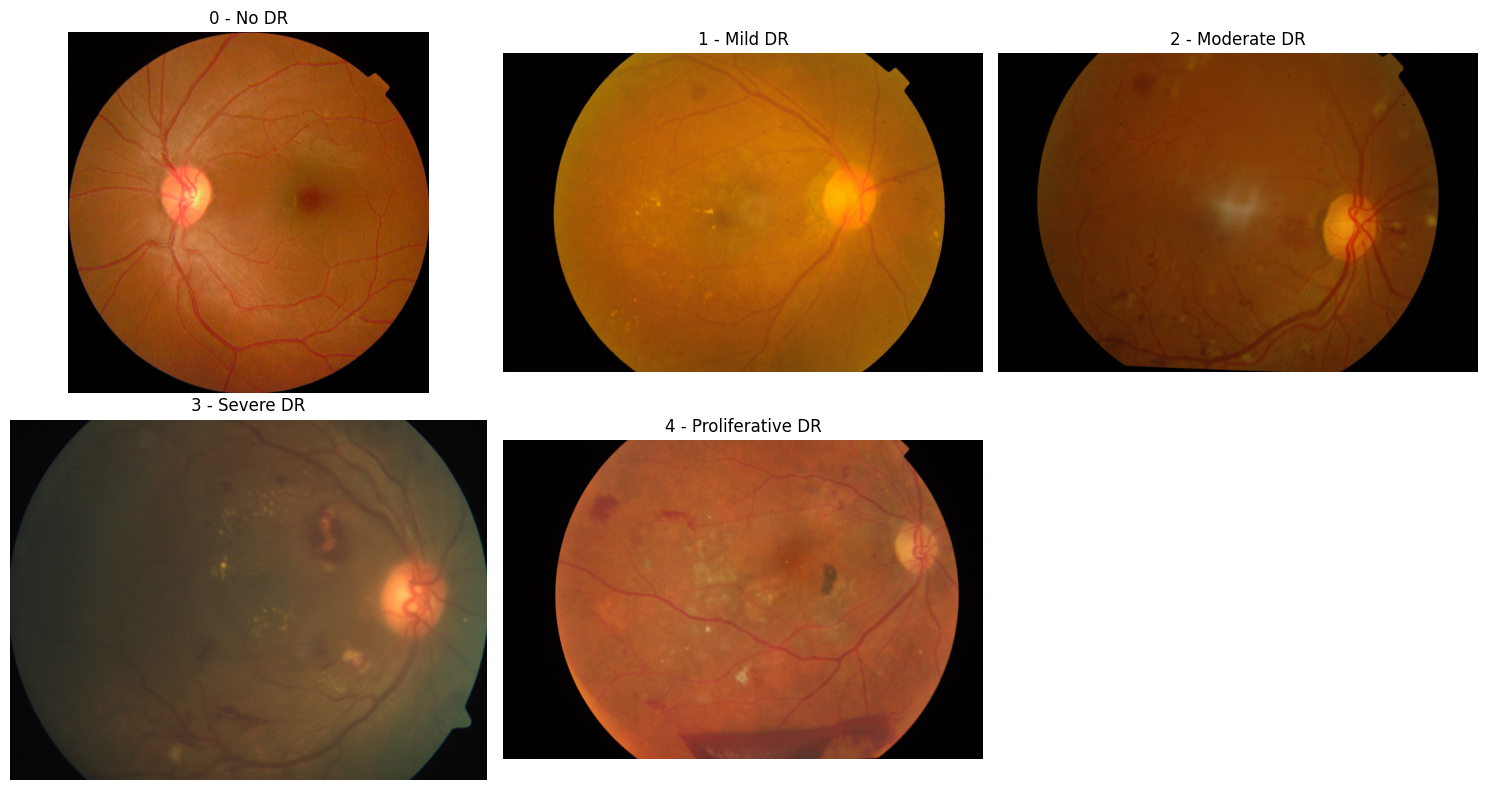

In [10]:
# Display the sample images

plt.figure(figsize = (15,8))

for i, cls in enumerate(sorted(train_df['diagnosis'].unique())):
  sample = train_df[train_df['diagnosis'] == cls].iloc[0]
  img = Image.open(sample['image_path'])

  plt.subplot(2, 3, i + 1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"{cls} - {label_info[cls]}")

plt.subplot(2,3,6)
plt.axis('off')
plt.tight_layout()
plt.show()

## **Image Preprocessing (Data Augmentation + Preprocessing Input as required for Pre-Trained Model)**

In [11]:
# Data Augmentation Parameter for Training Data
data_augment_train = ImageDataGenerator(
                                          preprocessing_function = preprocess_input,
                                          rotation_range = 20,
                                          width_shift_range = 0.05,
                                          height_shift_range = 0.05,
                                          shear_range = 0.05,
                                          zoom_range = 0.2,
                                          horizontal_flip = True
                                        )

# Data Augmentation Parameter for Validation and Test Data
data_augment_val_test = ImageDataGenerator(
                                            preprocessing_function = preprocess_input
                                          )

# Applying Data Augmentation on Training Data
train_data_gen = data_augment_train.flow_from_dataframe(
                                                          dataframe = train_df,
                                                          x_col = 'image_path',
                                                          y_col = 'diagnosis',
                                                          batch_size = 32,
                                                          target_size = (224, 224),
                                                          class_mode = 'categorical',
                                                          shuffle = True
                                                        )

# Applying Data Augmentation on Validation and Test Data
val_data_gen = data_augment_val_test.flow_from_dataframe(
                                                            dataframe = val_df,
                                                            x_col = 'image_path',
                                                            y_col = 'diagnosis',
                                                            batch_size = 10,
                                                            target_size = (224, 224),
                                                            class_mode = 'categorical',
                                                            shuffle = False
                                                        )

test_data_gen = data_augment_val_test.flow_from_dataframe(
                                                            dataframe = test_df,
                                                            x_col = 'image_path',
                                                            y_col = 'diagnosis',
                                                            batch_size = 10,
                                                            target_size = (224, 224),
                                                            class_mode = 'categorical',
                                                            shuffle = False
                                                        )

Found 2662 validated image filenames belonging to 5 classes.
Found 200 validated image filenames belonging to 5 classes.
Found 800 validated image filenames belonging to 5 classes.


## **Model Development**

#### **Convolutional Neural Networks (CNNs) using Pre-Trained Models**

#### **ResNet50 Model**

In [12]:
# Pre-Trained ResNet50 model
resnet50_pretrained_model = ResNet50(
                                include_top = False, # Included all the Convolutional Layers except the Fully-connected layers
                                weights = 'imagenet',
                                input_shape = (224,224,3)
                               )

# Feature Extraction (Freezing all the weights of convolutional layers)
resnet50_pretrained_model.trainable = False # Not re-training the weights of convolutional layers

# Summary of Pre-Trained ResNet50 model
resnet50_pretrained_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
# ResNet50 Architecture
fc_node_1 = 256
outer_node = num_classes
inner_activ = 'relu'
outer_activ = 'softmax'

resnet50_model = models.Sequential()

resnet50_model.add(resnet50_pretrained_model)

resnet50_model.add(Flatten())


# -- Fully Connected Layers --
resnet50_model.add(Dense(fc_node_1, activation = inner_activ))
resnet50_model.add(Dropout(0.2))
resnet50_model.add(Dense(outer_node, activation = outer_activ))

# Summary of Model
resnet50_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,279,365 (187.99 MB)

 Trainable params: 25,691,653 (98.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
# Compile the ResNet50 Model
grad_desc = keras.optimizers.Adam(learning_rate=1e-4)
loss_function = 'categorical_crossentropy'
performance = ['accuracy']

resnet50_model.compile(optimizer = grad_desc, loss = loss_function, metrics = performance)

# Handling Class Imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
class_weight_dict = dict(enumerate(class_weights))

# CallBack
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5,
                                           restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Fit the ResNet50 Model
resnet50_trained = resnet50_model.fit(train_data_gen,
                            steps_per_epoch = len(train_data_gen),
                            epochs = 20,
                            validation_data = val_data_gen,
                            validation_steps = len(val_data_gen),
                            class_weight = class_weight_dict,
                            callbacks=[early_stop, lr_scheduler]
                            )

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.5616 - loss: 2.3129 - val_accuracy: 0.6700 - val_loss: 0.7773 - learning_rate: 1.0000e-04
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6454 - loss: 1.1196 - val_accuracy: 0.6850 - val_loss: 0.6817 - learning_rate: 1.0000e-04
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6687 - loss: 1.0601 - val_accuracy: 0.7500 - val_loss: 0.6151 - learning_rate: 1.0000e-04
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6811 - loss: 0.9912 - val_accuracy: 0.7050 - val_loss: 0.7090 - learning_rate: 1.0000e-04
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6807 - loss: 0.9809 - val_accuracy: 0.7550 - val_loss: 0.6160 - learning_rate: 1.0000e-04
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7175 - loss: 0.9032 - val_accuracy: 0.7750 - val_loss: 0.5578 - learning_rate: 1.0000e-04
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.7168 

In [15]:
# History Table
resnet50_history_df = pd.DataFrame(resnet50_trained.history)
resnet50_history_df.rename(columns = {'loss':'train_loss', 'accuracy':'train_accuracy'}, inplace = True)

resnet50_history_df

train_accuracy  train_loss  val_accuracy  val_loss  learning_rate
0         0.561608    2.312910         0.670  0.777341        0.00010
1         0.645379    1.119613         0.685  0.681726        0.00010
2         0.668670    1.060074         0.750  0.615139        0.00010
3         0.681067    0.991239         0.705  0.708988        0.00010
4         0.680691    0.980867         0.755  0.615983        0.00010
5         0.717506    0.903248         0.775  0.557786        0.00010
6         0.716754    0.874738         0.755  0.623428        0.00010
7         0.716754    0.870337         0.785  0.584764        0.00010
8         0.720887    0.850255         0.815  0.543271        0.00010
9         0.745680    0.848576         0.790  0.542197        0.00010
10        0.746807    0.784564         0.835  0.508471        0.00010
11        0.764087    0.742670         0.815  0.536105        0.00010
12        0.767092    0.771864         0.735  0.606523        0.00010
13        0.750939    0.775817         0.765  0.572660        0.00010
14        0.770849    0.702620         0.815  0.531869        0.00002
15        0.775357    0.685978         0.820  0.520782        0.00002

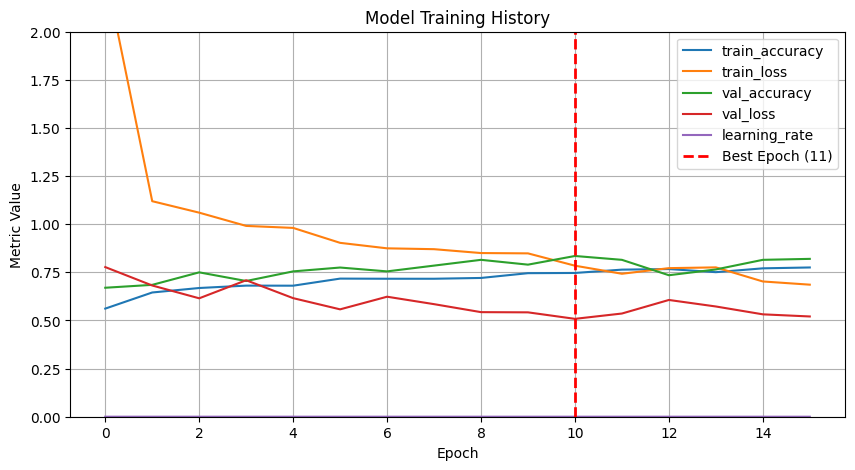

In [16]:
def plot_loss_acc(history_df, ylim_x=0, ylim_y=2):
    best_epoch_index = history_df['val_loss'].idxmin()
    history_df.plot(figsize=(10, 5))

    pyplot.axvline(
        x=best_epoch_index, 
        color='r', 
        linestyle='--', 
        linewidth=2,
        label=f'Best Epoch ({best_epoch_index + 1})'
    )
    
    pyplot.gca().set_ylim(ylim_x, ylim_y)
    pyplot.title('Model Training History')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Metric Value')
    pyplot.legend()
    pyplot.grid(True)
    pyplot.show()

plot_loss_acc(resnet50_history_df, ylim_x=0, ylim_y=2)

In [17]:
# Find the row with the minimum validation loss
best_epoch_row = resnet50_history_df.loc[resnet50_history_df['val_loss'].idxmin()]

# Extract the best metrics
best_train_loss = best_epoch_row['train_loss']
best_train_accuracy = best_epoch_row['train_accuracy']
best_val_loss = best_epoch_row['val_loss']
best_val_accuracy = best_epoch_row['val_accuracy']

# Print the Result
print("Training Accuracy: {:.2f}%".format(best_train_accuracy*100))
print("Validation Accuracy: {:.2f}%".format(best_val_accuracy*100))

Training Accuracy: 74.68%
Validation Accuracy: 83.50%


In [18]:
# Evaluate on Test Data
test_loss, test_acc = resnet50_model.evaluate(test_data_gen, steps=len(test_data_gen), verbose=1)

print("Test Accuracy: {:.2f}%".format(test_acc*100))

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 36s 437ms/step - accuracy: 0.7550 - loss: 0.6254
Test Accuracy: 75.50%


In [19]:
y_hat = resnet50_model.predict(test_data_gen, steps=len(test_data_gen))
y_hat.round(3)

80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 465ms/step


array([[0.   , 0.   , 0.574, 0.03 , 0.395],
       [0.995, 0.002, 0.004, 0.   , 0.   ],
       [0.773, 0.208, 0.019, 0.   , 0.001],
       ...,
       [0.002, 0.056, 0.553, 0.314, 0.075],
       [0.002, 0.024, 0.118, 0.323, 0.533],
       [1.   , 0.   , 0.   , 0.   , 0.   ]], dtype=float32)

In [20]:
y_hat_class = np.argmax(y_hat, axis = 1)
y_hat_class

array([2, 0, 0, 0, 1, 3, 2, 2, 2, 0, 4, 0, 3, 0, 1, 0, 0, 2, 0, 2, 3, 0,
       2, 0, 2, 2, 4, 1, 2, 4, 2, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 4, 2,
       1, 0, 0, 1, 3, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 2, 0, 1, 0, 2,
       0, 2, 1, 0, 2, 2, 2, 3, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 2, 0, 0, 2, 4, 2, 3, 0, 0, 0, 0, 1, 0, 2, 1, 4, 4, 0, 4, 3, 0,
       1, 0, 1, 3, 1, 0, 0, 2, 0, 0, 2, 3, 1, 0, 2, 1, 0, 0, 0, 1, 1, 0,
       2, 0, 0, 2, 0, 2, 2, 2, 1, 0, 1, 2, 0, 1, 2, 3, 0, 4, 0, 3, 0, 3,
       0, 0, 4, 1, 1, 2, 0, 2, 0, 0, 1, 0, 3, 0, 0, 0, 4, 0, 2, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 4, 1, 2, 0, 0, 4, 0, 0, 2, 2, 0, 4, 0, 2, 1, 2,
       2, 2, 0, 1, 0, 0, 1, 2, 0, 1, 0, 4, 0, 2, 3, 4, 0, 0, 0, 0, 4, 0,
       4, 0, 2, 2, 0, 2, 0, 1, 0, 0, 0, 3, 3, 1, 0, 2, 2, 0, 0, 0, 4, 0,
       1, 0, 0, 2, 4, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0, 3, 0, 0, 1, 0, 3, 0,
       2, 0, 0, 0, 1, 1, 2, 0, 0, 2, 0, 2, 4, 2, 0, 3, 2, 0, 2, 1, 0, 3,
       0, 2, 2, 1, 0, 3, 0, 0, 4, 3, 2, 4, 1, 0, 0,

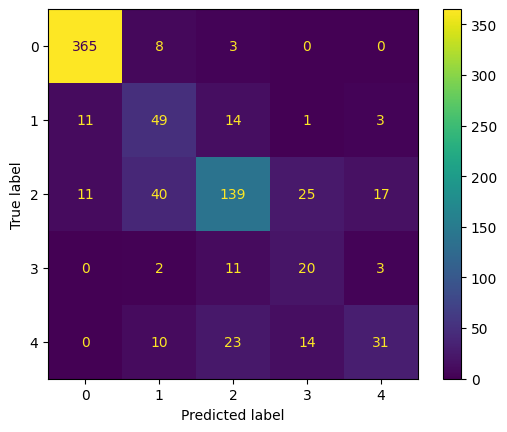

In [21]:
y_true = test_df['diagnosis'].astype(int).values
y_pred = np.array(y_hat_class).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix heatmap
display = ConfusionMatrixDisplay(confusion_matrix = cm)
display.plot()

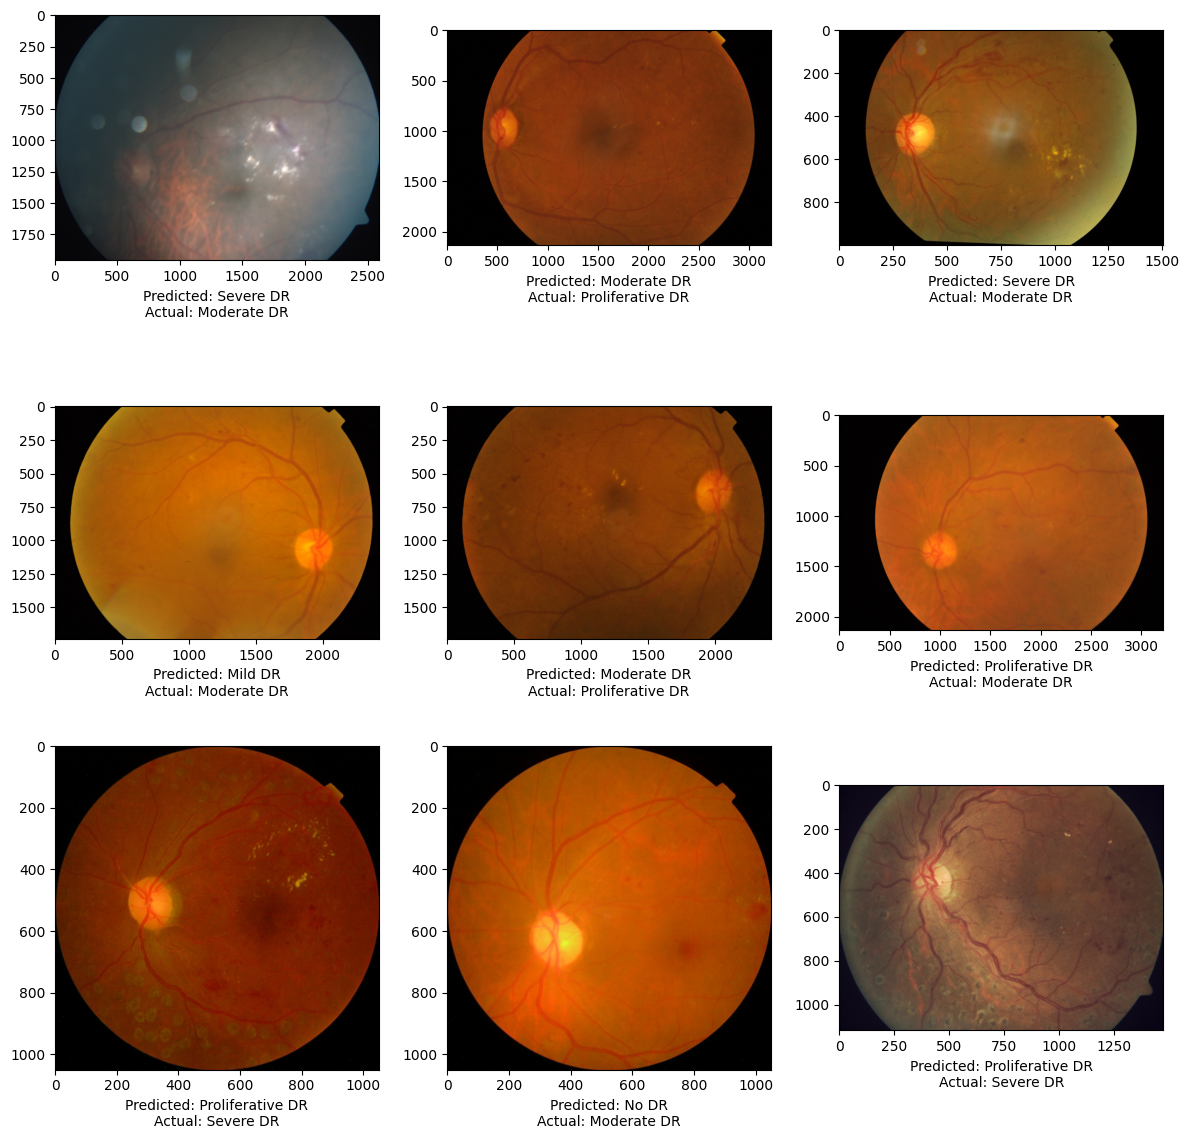

In [29]:
errorCnt = 9
tCnt = 0
index = 0

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

while tCnt < errorCnt and index < len(test_df):
    actual_class = int(test_df.loc[index, 'diagnosis'])
    img_path = test_df.loc[index, 'image_path']
    pred_class = y_hat_class[index]

    if pred_class != actual_class:
        img = mpimg.imread(img_path)
        axes.flat[tCnt].imshow(img)
        axes.flat[tCnt].set_xlabel(
            f"Predicted: {class_names[pred_class]}\nActual: {class_names[actual_class]}"
        )
        tCnt += 1
    index += 1

plt.tight_layout()
plt.show()

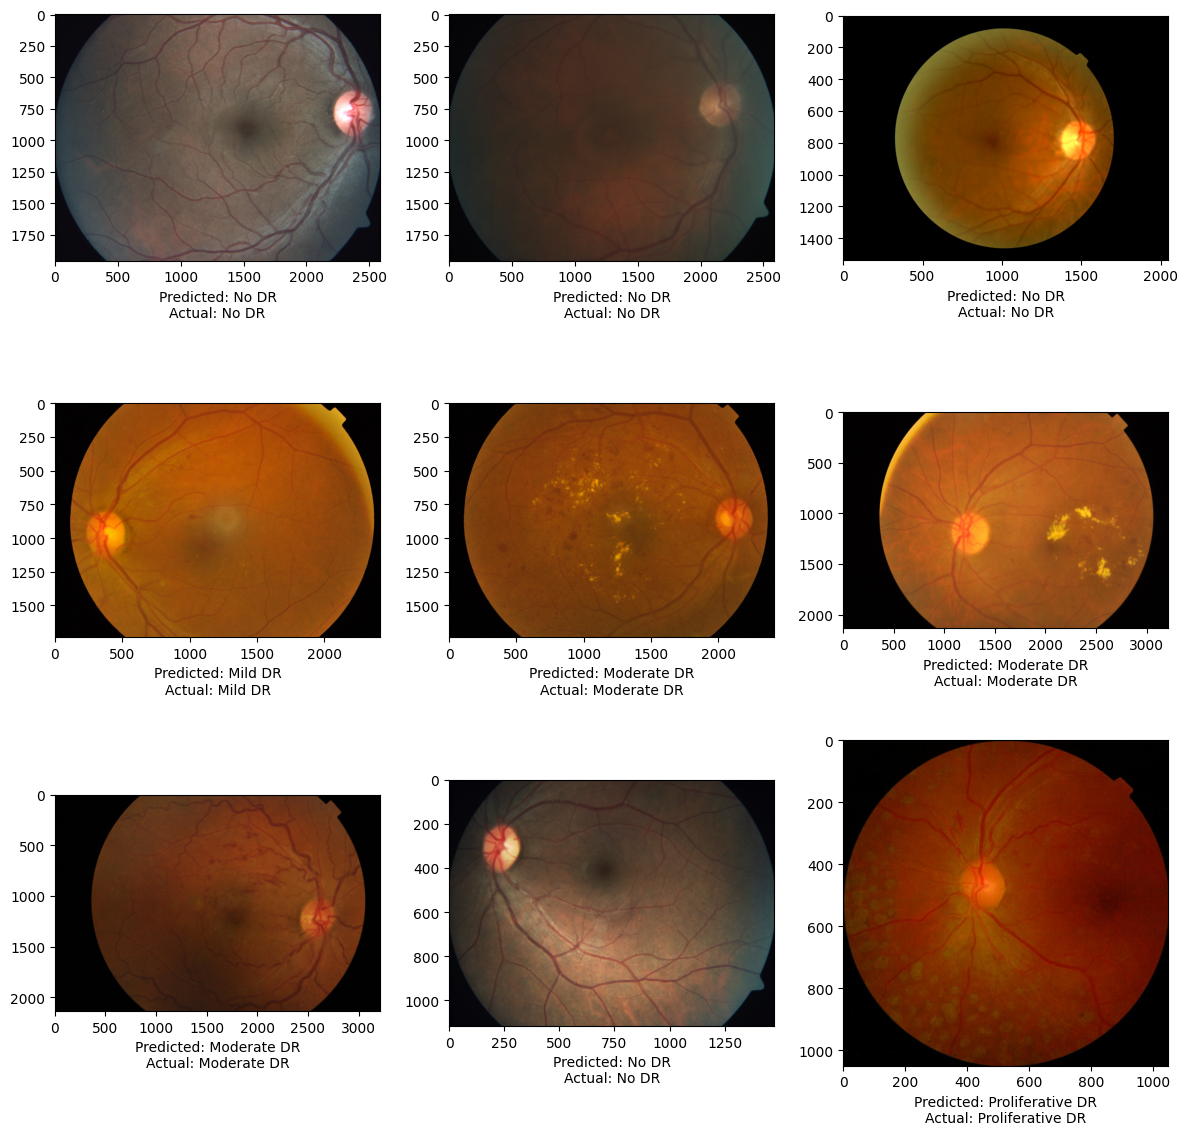

In [30]:
errorCnt = 9
tCnt = 0
index = 0

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

while tCnt < errorCnt and index < len(test_df):
    actual_class = int(test_df.loc[index, 'diagnosis'])
    img_path = test_df.loc[index, 'image_path']
    pred_class = y_hat_class[index]

    if pred_class == actual_class:
        img = mpimg.imread(img_path)
        axes.flat[tCnt].imshow(img)
        axes.flat[tCnt].set_xlabel(
            f"Predicted: {class_names[pred_class]}\nActual: {class_names[actual_class]}"
        )
        tCnt += 1
    index += 1

plt.tight_layout()
plt.show()